<a href="https://colab.research.google.com/github/ziadelsharawy/Test/blob/main/NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding,SimpleRNN,SpatialDropout1D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
cols_names = ['Tweet_ID','Company','Sentiment','Tweet']
df = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",names=cols_names)
val_data = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",names=cols_names)
df.head()

,Tweet_ID,Company,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.tail()

,Tweet_ID,Company,Sentiment,Tweet
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...
74681,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [ ]:
val_data.head()

,Tweet_ID,Company,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
df.shape

(74682, 4)

In [ ]:
val_data.shape

(1000, 4)

In [ ]:
df["Sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [ ]:
df["Company"].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74682 non-null  int64 
 1   Company    74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df["Sentiment"].value_counts()

Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

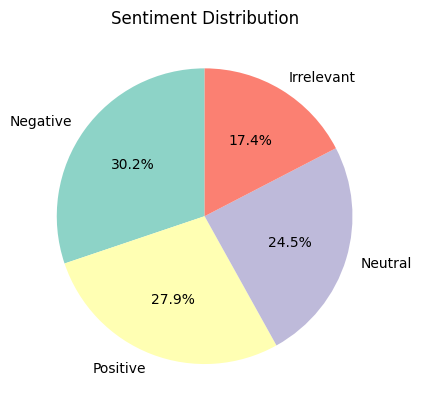

In [ ]:
sentiment_counts = df["Sentiment"].value_counts()
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()

In [ ]:
df = df.drop("Tweet_ID", axis=1)
df = df.drop("Company", axis=1)
df.head()

,Sentiment,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.isnull().sum()

Sentiment      0
Tweet        686
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

Sentiment    0
Tweet        0
dtype: int64

In [ ]:
# df.duplicated().sum()

In [ ]:
# df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

4227

In [ ]:
df['Tweet'].apply(len).max()

957

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
print(df.index)

RangeIndex(start=0, stop=73996, step=1)


In [ ]:
ps=PorterStemmer()
corpus=[]
for i in range(len(df)):
    z=re.sub('[^a-zA-Z]'," ",df['Tweet'][i])
    z=z.lower()
    z=z.split()
    z=[word for word in z if word not in stopwords.words('english') ]
    z=' '.join(z)
    z=ps.stem(z)
    corpus.append(z)
corpus

['im getting borderlands murd',
 'coming borders kil',
 'im getting borderlands kil',
 'im coming borderlands murd',
 'im getting borderlands murd',
 'im getting borderlands murd',
 'spent hours making something fun know huge borderlands fan maya one favorite characters decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent couple hours something fun know huge borderlands fan maya one favorite characters decided make wallpaper pc original picture compared creation made fun pic twitter com mlsi wf jg',
 'spent hours something fun know huge borderlands fan maya one favorite charact',
 'spent hours making something fun know huge rhandlerr fan maya one favorite characters decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent hours making something fun know huge rhandlerr fan maya one favorite characters decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=100)

In [ ]:
X

array([[   0,    0,    0, ...,  188,   93,   69],
       [   0,    0,    0, ...,    0,  300,  844],
       [   0,    0,    0, ...,   93,   69,  844],
       ...,
       [   0,    0,    0, ...,   54, 1223,  379],
       [   0,    0,    0, ...,   34,  379,   84],
       [   0,    0,    0, ...,  611, 1223,  379]], dtype=int32)

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])
y = to_categorical(y, num_classes=4)

In [ ]:
vocab_size = max_features
embedding_dim = 128
max_sequence_length = 100
num_classes = 4

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.build(input_shape=(None, max_sequence_length))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,004 (1.33 MB)

 Trainable params: 348,004 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape,X_test.shape

((49577, 100), (24419, 100))

In [ ]:
y_train.shape,y_test.shape

((49577, 4), (24419, 4))

In [ ]:
batch_size = 32
model.fit(X_train, y_train, epochs = 15, batch_size=batch_size, verbose = 2)

Epoch 1/15
1550/1550 - 196s - 127ms/step - accuracy: 0.5622 - loss: 1.0388
Epoch 2/15
1550/1550 - 192s - 124ms/step - accuracy: 0.6476 - loss: 0.8686
Epoch 3/15
1550/1550 - 191s - 123ms/step - accuracy: 0.6826 - loss: 0.7871
Epoch 4/15
1550/1550 - 191s - 123ms/step - accuracy: 0.7085 - loss: 0.7266
Epoch 5/15
1550/1550 - 191s - 123ms/step - accuracy: 0.7325 - loss: 0.6732
Epoch 6/15
1550/1550 - 190s - 123ms/step - accuracy: 0.7532 - loss: 0.6226
Epoch 7/15
1550/1550 - 187s - 121ms/step - accuracy: 0.7715 - loss: 0.5777
Epoch 8/15
1550/1550 - 188s - 121ms/step - accuracy: 0.7882 - loss: 0.5353
Epoch 9/15
1550/1550 - 187s - 121ms/step - accuracy: 0.8032 - loss: 0.5005
Epoch 10/15
1550/1550 - 187s - 121ms/step - accuracy: 0.8146 - loss: 0.4694
Epoch 11/15
1550/1550 - 201s - 130ms/step - accuracy: 0.8276 - loss: 0.4360
Epoch 12/15
1550/1550 - 187s - 121ms/step - accuracy: 0.8357 - loss: 0.4144
Epoch 13/15
1550/1550 - 187s - 120ms/step - accuracy: 0.8449 - loss: 0.3914
Epoch 14/15
1550/1550

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7890


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

764/764 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.74      4415
           1       0.84      0.82      0.83      7271
           2       0.81      0.76      0.79      5970
           3       0.72      0.85      0.78      6763

    accuracy                           0.79     24419
   macro avg       0.80      0.78      0.78     24419
weighted avg       0.79      0.79      0.79     24419



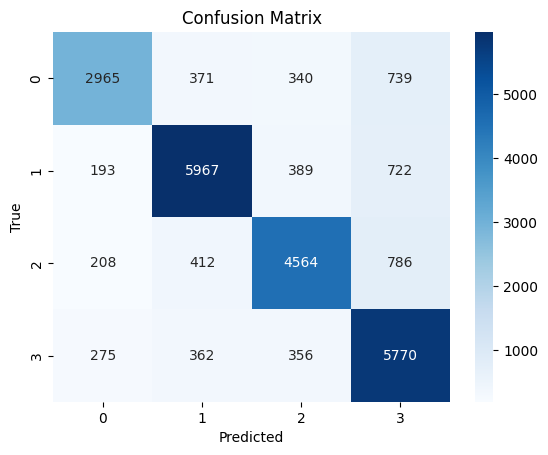

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def preprocess_text(text, tokenizer, max_sequence_length):
    ps = PorterStemmer()
    text = re.sub('[^a-zA-Z]', " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    text = ps.stem(text)

    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    return padded_sequence

new_tweet = "I absolutely love this product! It's fantastic."

processed_tweet = preprocess_text(new_tweet, tokenizer, max_sequence_length)

prediction = model.predict(processed_tweet)
predicted_class = np.argmax(prediction, axis=1)[0]

class_labels = label_encoder.classes_
predicted_sentiment = class_labels[predicted_class]

print(f"Tweet: {new_tweet}")
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tweet: I absolutely love this product! It's fantastic.
Predicted Sentiment: Positive


In [ ]:
def preprocess_text(text, tokenizer, max_sequence_length):
    ps = PorterStemmer()
    text = re.sub('[^a-zA-Z]', " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    text = ps.stem(text)

    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    return padded_sequence

new_tweet = "@Microsoft Why do I pay for WORD when it funct..."

processed_tweet = preprocess_text(new_tweet, tokenizer, max_sequence_length)

prediction = model.predict(processed_tweet)
predicted_class = np.argmax(prediction, axis=1)[0]

class_labels = label_encoder.classes_
predicted_sentiment = class_labels[predicted_class]

print(f"Tweet: {new_tweet}")
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tweet: @Microsoft Why do I pay for WORD when it funct...
Predicted Sentiment: Negative


In [ ]:
def preprocess_text(text, tokenizer, max_sequence_length):
    ps = PorterStemmer()
    text = re.sub('[^a-zA-Z]', " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    text = ps.stem(text)

    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    return padded_sequence

new_tweet = "Now the President is slapping Americans in the..."

processed_tweet = preprocess_text(new_tweet, tokenizer, max_sequence_length)

prediction = model.predict(processed_tweet)
predicted_class = np.argmax(prediction, axis=1)[0]

class_labels = label_encoder.classes_
predicted_sentiment = class_labels[predicted_class]

print(f"Tweet: {new_tweet}")
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tweet: Now the President is slapping Americans in the...
Predicted Sentiment: Neutral


In [ ]:
vocab_size = max_features  # Ensure this matches tokenizer's num_words
embedding_dim = 128
max_sequence_length = 100
num_classes = 4

# Build the RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_rnn.add(SpatialDropout1D(0.2))
model_rnn.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by providing a sample input
model_rnn.build(input_shape=(None, max_sequence_length))

# Display the model summary
model_rnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100)            │        22,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,304 (1.07 MB)

 Trainable params: 279,304 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
model_rnn.fit(X_train, y_train, epochs = 50, batch_size=batch_size, verbose = 2)

Epoch 1/50
1550/1550 - 20s - 13ms/step - accuracy: 0.4077 - loss: 1.2822
Epoch 2/50
1550/1550 - 14s - 9ms/step - accuracy: 0.5342 - loss: 1.0997
Epoch 3/50
1550/1550 - 14s - 9ms/step - accuracy: 0.5743 - loss: 1.0257
Epoch 4/50
1550/1550 - 14s - 9ms/step - accuracy: 0.6250 - loss: 0.9233
Epoch 5/50
1550/1550 - 14s - 9ms/step - accuracy: 0.6525 - loss: 0.8634
Epoch 6/50
1550/1550 - 14s - 9ms/step - accuracy: 0.6691 - loss: 0.8260
Epoch 7/50
1550/1550 - 14s - 9ms/step - accuracy: 0.6818 - loss: 0.7923
Epoch 8/50
1550/1550 - 14s - 9ms/step - accuracy: 0.6942 - loss: 0.7687
Epoch 9/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7062 - loss: 0.7456
Epoch 10/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7115 - loss: 0.7286
Epoch 11/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7203 - loss: 0.7103
Epoch 12/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7243 - loss: 0.6979
Epoch 13/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7315 - loss: 0.6812
Epoch 14/50
1550/1550 - 14s - 9ms/step - accuracy: 0.7377 -

In [ ]:
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7238


In [ ]:
y_pr = model_rnn.predict(X_test)
y_pred_cl = np.argmax(y_pr, axis=1)
y_t= np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_t, y_pred_cl))

764/764 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64      4415
           1       0.78      0.77      0.77      7271
           2       0.74      0.68      0.71      5970
           3       0.67      0.80      0.73      6763

    accuracy                           0.72     24419
   macro avg       0.73      0.71      0.71     24419
weighted avg       0.73      0.72      0.72     24419



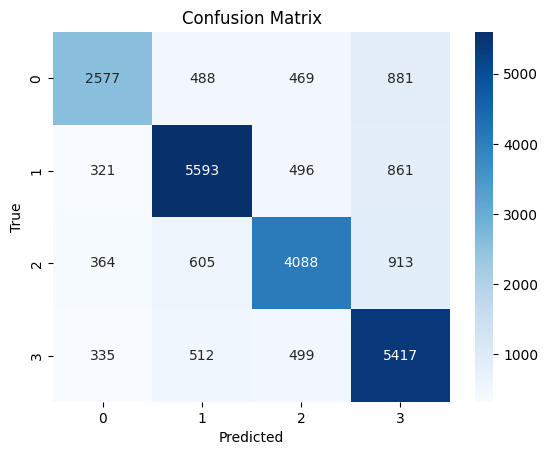

In [ ]:
cm = confusion_matrix(y_t, y_pred_cl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def preprocess_text(text, tokenizer, max_sequence_length):
    ps = PorterStemmer()
    text = re.sub('[^a-zA-Z]', " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    text = ps.stem(text)

    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    return padded_sequence

new_tweet = "I absolutely love this product! It's fantastic."

processed_tweet = preprocess_text(new_tweet, tokenizer, max_sequence_length)

prediction = model_rnn.predict(processed_tweet)
predicted_class = np.argmax(prediction, axis=1)[0]

class_labels = label_encoder.classes_
predicted_sentiment = class_labels[predicted_class]

print(f"Tweet: {new_tweet}")
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Tweet: I absolutely love this product! It's fantastic.
Predicted Sentiment: Positive
